# 1. 라이브러리 불러오기

In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [3]:
!pip install ipywidgets

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact

# 2. 이미지 파일경로 불러오기

In [5]:
def list_image_file(data_dir, sub_dir): #    './Covid19-dataset/train/'   ,  'Normal'
    image_format = ['jpeg','jpg','png']
    image_files = []
    
    images_dir = os.path.join(data_dir, sub_dir) # './Covid19-dataset/train/Normal'
    
    # os.path.join : 경로를 합쳐줌
    # 각각의 코로나,일반, 폐렴의 폴더가 다르니까 나눠서 합친다
    
    for file_path in os.listdir(images_dir): # 안에 있는 파일,폴더 다 가져와서 리스트화시킴
        if file_path.split(".")[-1] in image_format:
            # .으로 구분해서 앞은 파일이름, 뒤는 확장명이므로 -1은 확장명이다
            # 이미지포맷안에 들어가있다면 빈 리스트(image_files = [])안에 append시킨다,
            image_files.append(os.path.join(sub_dir, file_path)) # append시켜서 image_files = []에 쌓는다
    return image_files
            

In [6]:
data_dir = 'C:/python/Project/Covid-19/Covid19-dataset/train/'

normals_list = list_image_file(data_dir, 'Normal') # 경로 두개를 합쳐서 리턴시킴
covids_list = list_image_file(data_dir, 'Covid')
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [7]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


# 3. 이미지파일을 RGB 3차원 배열로 불러오기

In [8]:
def get_RGB_image(data_dir, file_name): # 
    image_file = os.path.join(data_dir, file_name) # 경로화시킨다.
    # join하는 이유는 경로인식이 안돼서 join을 사용. string으로 못함
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# 4. 이미지 데이터 시각화하기

In [9]:
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list)) 
# 각 70,111,70개인데 최소70개니까 중간에 있는 41개를 포기하고 최소 70개 선택



@interact(index = (0, min_num_files -1)) # index가 0부터이기 때문에 70개니까 69까지 범위를 줌
def show_samples(index = 0):
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize = (12, 8))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_image)
    

    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_image)
    

    plt.subplot(133)
    plt.title('Pneumonia')
    plt.imshow(pneumonia_image)
    
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 5. 학습데이터셋 클래스 만들기
* 데이터셋 : 데이터(샘플,정답)을 저장한 것
* 데이터로더 : 데이터셋을 접근하기 쉽게 객체(tierable)로 감싼 것

In [10]:
train_data_dir = './Covid19-dataset/train/'
class_list = ['Normal','Covid','Viral Pneumonia']

In [11]:
class Chest_dataset(Dataset):
    # __init__(): dataset객체를 만들때 얘가 실행됨
    # __len__(): data의 갯수를 알아낼수 있는 메소드
    # __getitem__(): 여기서 image와 label을 리턴시켜주는것을 만듦. 
    #                데이터를index로 불러들이면 이 메소드가 호출
    
    # 이렇게 세개가 필요함
    
    
    def __init__(self, data_dir, transform=None): 
        # transform은 train인지 test인지 구분하기 위해서 
        self.data_dir = data_dir # self를 붙이면 다른 메소드안에서 쓸 수 있음
                                 # self를 안 쓰면 이 메소드 안에서만 쓸 수 있음
        normals = list_image_file(data_dir, 'Normal') # 리스트를 뽑아와서 normals에 저장
                                                      # normals는 self안붙였으니 이 메소드안에서만 사용
        covids = list_image_file(data_dir, 'Covid') 
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        
        self.files_path = normals + covids + pneumonias # 각각 리스트를 다 더해서 files_path에 저장 
        self.transform = transform
        
        
        
    def __len__(self): # 스페셜메소드. 오버라이딩(덮어쓰기)
        return len(self.files_path) # files_path에 있는 리스트의 길이를 리스트로 ?????
        
    
    
    def __getitem__(self, index): # 인덱스의 순서에 있는 것을 찾아주는
        # 인덱싱하게되면 호출하게되는 메소드
        image_file = os.path.join(self.data_dir, self.files_path[index])
        
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = class_list.index(self.files_path[index].split(os.sep)[-2]) # 정답
        target = class_list.index(self.files_path[index].split(os.sep)[0])
        # os.sep : 디렉토리 분리 문자를 리턴(/), Normal/01.jpeg
        # -2는 Normal,  0은 01.jpeg
        
        if self.transform:  # self.transform에 데이터가 있으면 (none이 아니라면)
            image = self.transform(image) # 
            target = torch.Tensor([target]).long()
            
        return{'image':image, 'target':target}

In [12]:
dset = Chest_dataset(train_data_dir)

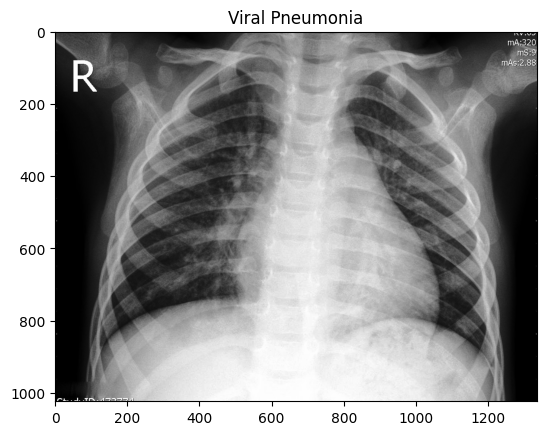

In [13]:
index = 200

plt.title(class_list[dset[index]['target']]) 
#폐렴인지, 정상인인지, 코로나인지 말이 'target'에 찍힘
plt.imshow(dset[index]['image']) 
# 위에 이름붙여지고 아래엔 흉부사진이 붙여짐

# 6. 배열을 연산가능한 텐서로 변환하기

In [14]:
# transforms.ToTensor()를 사용하여 텐서로 변환시키고, 픽셀값의 범위를 0~1로 조정
# 각 채널의 평균을 0.5, 표준편차를 0.5로 정규화 적용


transformer = transforms.Compose([ 
    # compose() : 한꺼번에 여러개를 적용하기위한 함수. 
    # 특정값, 특정리스터에 한꺼번에 적용하고싶을때 사용함.
    
    
    transforms.ToTensor(), # transforms의 모든 값을 텐서로 바꾸기
    transforms.Resize((224,224)), # 이미지 사이즈를 (224,224)로 바꿔주기
                                  # 뒤에 쓸 모델인 vgg19이 입력받는 크기가 224,224이기때문에 
    transforms.Normalize(mean=[0.5,0.5,0.5], # RGB색상을 모두 0.5로 평균을 맞추기
                        std=[0.5,0.5,0.5]) # 값들의 범위를 모두 0.5로 맞추기 
                                           # 연산속도 빠르게하기위해)
                                           # 정규화하는 이유는 척도가 다르니까 
    
])

In [15]:
train_dset = Chest_dataset(train_data_dir, transformer) 
# dataset클래스안에 넣어줌 ( 경로, transfomer 객체)
# __init__()안에있는 fransform=None이 True로 되고 

In [16]:
index = 200
image = train_dset[index]['image']
label = train_dset[index]['target']

In [17]:
print(image.shape, label) # 0은 정상 1는 코로나, 2는 폐렴

torch.Size([3, 224, 224]) tensor([2])


# 7. 데이터로더 구현하기

In [18]:
# train_data_dir, val_data_dir 그 둘을 받아서 데이터로더 구현
# train시키는 로더랑, valid하는 로더랑 따로 넣었는데 이번엔 합쳐보기

def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    # {'train' : }
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True)
    # drop_last : batch_size를 4씩으로 쪼개면 자투리가 남는데, 그 자투리가 남은 것은 버려라

    
    val_dset = Chest_dataset(val_data_dir, transformer) 
    # train이 아니니까 transformer는 넣을필요 없다
    
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    # shuffle, drop_last할 필요가 없다
    
    return dataloaders

In [19]:
train_data_dir = 'C:\python\Project\Covid-19/Covid19-dataset/train/'
val_data_dir = 'C:\python\Project\Covid-19/Covid19-dataset/test/'

dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [20]:
for i, d in enumerate(dataloaders['train']): # 인덱스값과 실제 데이터 값 출력
    print(i, d) # i는 0, d는 나머지 전부 # 타겟도 들어
    if i == 0: # 너무많으니까 1개만 돌리게 if문사용
        break
        
        # 1은 코로나 0은 정상, 2는 폐렴

0 {'image': tensor([[[[-0.8901, -0.8824, -0.8906,  ..., -0.9068, -0.9285, -0.9292],
          [-0.9055, -0.8773, -0.8992,  ..., -0.9137, -0.9199, -0.9136],
          [-0.8744, -0.9100, -0.9056,  ..., -0.9007, -0.9173, -0.9062],
          ...,
          [-0.9230, -0.9085, -0.9012,  ..., -0.8824, -0.8794, -0.8913],
          [-0.9134, -0.9059, -0.9132,  ..., -0.8818, -0.8824, -0.8901],
          [-0.9144, -0.8902, -0.9010,  ..., -0.8818, -0.8748, -0.8900]],

         [[-0.8901, -0.8824, -0.8906,  ..., -0.9068, -0.9285, -0.9292],
          [-0.9055, -0.8773, -0.8992,  ..., -0.9137, -0.9199, -0.9136],
          [-0.8744, -0.9100, -0.9056,  ..., -0.9007, -0.9173, -0.9062],
          ...,
          [-0.9230, -0.9085, -0.9012,  ..., -0.8824, -0.8794, -0.8913],
          [-0.9134, -0.9059, -0.9132,  ..., -0.8818, -0.8824, -0.8901],
          [-0.9144, -0.8902, -0.9010,  ..., -0.8818, -0.8748, -0.8900]],

         [[-0.8901, -0.8824, -0.8906,  ..., -0.9068, -0.9285, -0.9292],
          [-0.9055

In [21]:
d['target'].shape

torch.Size([4, 1])

In [22]:
d['target'].squeeze() # 1: 코로나, 2: 폐렴, 0: 정상

tensor([0, 1, 2, 0])

# 8. Classification 모델(VGG19) 불러오기

In [23]:
model = models.vgg19(pretrained=True)
# pretrained = True : 미리 학습된 weight들을 가지고 옴

c:\users\jkkim\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\users\jkkim\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# pytorch 모델을 summary해주는 모듈
!pip install torchsummary

In [25]:
from torchsummary import summary

In [26]:
summary(model, (3, 224, 224), batch_size=1, device='cpu') # 3채널짜리 224*224인 shape, 

#  MaxPool2d-37 까지가 cnn
# AdaptiveAvgPool2d-38 부터 FC모델 

# 마지막에 1000개가 나오니까 3개에 맞게 (정상, 코로나, 폐렴) 분류할 것

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 8-1. CNN
* 합성곱 인공 신경망
* 전통적인 뉴럴 네트워크 앞에 컨볼루셔널 계층을 붙인 형태
* 컨볼루셔널 계층을 통해서 입력 받은 이미지에 대한 특징(Feature)을 추출하게 되고, 추출한 특징을 기반으로 기존의 뉴럴 네트워크에 이용하여 분류

# 8-1. CNN을 사용하는 이유
* 영상을 분류할때 DNN(Deep Neural Network)의 문제점
    * 일반적인 DNN은 1차원 형태의 데이터를 사용
    * 2차원의 형태의 이미지가 입력되는 경우, flatten 시켜서 한줄로 데이터를 넣음
    * 이미지의 공간적/지역적 정보가 손실
* DNN의 문제점을 해결하기 위해 고안한 해결책 -> 이미지를 날것(raw input) 그대로 받음으로 공간적/지역적 정보를 유지

# 8-2. 컨볼루셔널 레이러(Convolutional Layer)
* 입력 데이터로부터 특징을 추출하는 역할
* 특징을 추출하는 필터(Filter)를 사용함(https://setosa.io/ev/image-kernels/)
* 필터의 값을 비선형 값으로 바꿔주는 엑티베이션(Activation)함수를 사용
* 필터를 통해 연산을 하고 나온 데이터에 엑티베이션 함수(주로 ReLU)에 넣어 이미지 맵을 그림

# 8-3. 풀링(pooling)
* Feature map의 사이즈를 줄이는 방법
* 데이터의 크기를 줄이고 싶을 때 선택적으로 사용
* max pooling : 사이즈를 점진적으로 줄이는 방법. 선명한 정보만 남겨서 판단과 학습이 쉬워지고 노이즈가 줄여듬

# 8-4. 패딩(padding)
* CNN 네트워크 특징 중 여러 단계에 걸쳐서 계속 필터를 연속적으로 적용하면 필터 적용 후에 결과값이 처음에 비해 작아지게 됨 -> 특징이 유실될 수 있음
* 충분히 특징이 추출되기 전에 결과 값이 작이지지 않도록 패딩 기법을 사용
* 입력값 주위로 0을 넣어서 입력 값의 크기를 인위적으로 키워 결과갑이 작아지는 것을 방지

# 8-5. 스트라이드(stride)
* 필터를 적용하는 간격(예 : 우측으로 한칸씩 아래로 한칸씩 적용)을 설정
* 필터를 적용해서 얻어낸 결과를 Feature map 또는 activation map이라고 부름

# 8-6. 드롭아웃 레이어(dropout layter)
* 오버피팅을 막기 위한 방법
* 뉴럴 네트워크가 학습중일때 랜덤하게 값을 발생하여 학습을 방해함으로 학습용 데이터에 결과가 치우치는 것을 방지함

# 8-7. FC Layer(Fully Connected Layer)
* 이미지를 분류/설명하기 위해 예측하는 구간

In [27]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# 9. 데이터에 맞게 모델 Head 부분을 수정하기

In [28]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

model.classifier = nn.Sequential(
    nn.Flatten(), # cnn은 이미지의 위치값을 가지고있는 행렬모델인데, FC쪽으로 가져오면 평평하게 만들어야한다.
    nn.Linear(512, 256), # cnn마지막형태가 (34): Conv2d(512, 512) 이므로 반으로 줄여준다. 항상 2의 배수
    nn.ReLU(),
    nn.Dropout(0.1), # 과대적합나오지않게 10프로만 이상한 값 넣기
    nn.Linear(256, len(class_list)), # 256으로 줄였으니까 256으로 받고, list의 갯수만큼 계산해서 바꿔줌
    nn.Sigmoid() # 참인지 거짓인지 바꿔서 밖으로 보내줌
    
)

In [29]:
# 위에 한것을 함수화 시킴

def build_vgg19_based_model(device_name='cpu'):
    device = torch.device(device_name)
    model = models.vgg19(pretrained=True) # 미리 학습된 정보를 가져와서 학습시킴
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) 
    
    model.classifier = nn.Sequential( # sequential : 레이어를 만들어주는 함수
        nn.Flatten(), # cnn은 이미지의 위치값을 가지고있는 행렬모델인데, FC쪽으로 가져오면 평평하게 만들어야한다.
        nn.Linear(512, 256), # cnn마지막형태가 (34): Conv2d(512, 512) 이므로 반으로 줄여준다. 항상 2의 배수
                            # 512 데이터를 받아서 256으로 내보냄
        nn.ReLU(),
        nn.Linear(256, len(class_list)), # 256으로 줄였으니까 256으로 받고, list의 갯수만큼 계산해서 바꿔줌
        nn.Softmax(dim=1) # 3개의 데이터를 1개의 확률로 바꿔주는?
    )
    return model.to(device)

In [30]:
model = build_vgg19_based_model(device_name='cpu')

In [31]:
summary(model, (3, 224, 224), batch_size=1, device='cpu') # 3채널짜리 224*224, 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

# 10. 손실함수(loss function) 불러오기
* input x에 대한 예측값과 실제값 사이의 오차를 계산하는 함수
* cost function : 모든 input dataset에 대하여 오차를 계산하는 함수

In [32]:
loss_func = nn.CrossEntropyLoss(reduction='mean')

# 11. Gradient 최적화 함수 불러오기

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

# model.parameter()에 기울기값을 넣어줌. 
# 로컬미니멀에 빠지지않게 모멘텀을 쓴다

# 11-1. 경사하강법의 종류
* 배치 경사 하강법
    * 가장 기본적인 경사 하강법으로 Vanilla Gradient Descent라고 부름
    * 데이터셋 전체를 고려하여 손실함수를 계싼
    * 한 번의 Epoch에 모든 파라미터 업데이터를 단 한번만 수행
    * batch의 갯수와 literation은 1이고 batch size는 전체 데이터의 갯수
    * 파라미터 업데이트할 때 전체 데이터셋을 고려하기 때문에 모델 학습 시 많은 시간과 메모리가 필요하다는 단점
    
* 확률적 경사 하강법(Stochastic Gradient Descent)
    * 배치 경사 하강법이 모델 학습 시 많은 시간과 메모리가 필요하다는 단점을 개선하기 위해 제안된 기법
    * batch size를 1로 설정하여 파라미터를 업데이트하기 때문에 배치 경사 하강법보다 빠르고 적은 메모리로 학습이 진행
    * 중복 데이터를 뽑을 가능성이 있음
    * 파라미터 값의 업데이트 폭이 불안정
    
* 미니 배치 경사 하강법
    * batch size가 1도 아니고, 전체 데이터 갯수도 아닌 경우
    * 배치 경사 하강법보다 모델 학습 속도가 빠르고, 확률적 경사 하강법보다 안정적인 장점이 있음
    * 일반적으로 batch size를 2의 n제곱에 해당하는 값으로 설정

# 11-2. 경사 하강법 알고리즘
* GD(gradiant descent)
    * 모든 데이터를 사용하여 계산하는 방법으로 학습시간이 오래 걸림
* SGD(Stochastic Gradient Descent)
    * 확률적 경사 하강법으로 모든 데이터에 대해 가중치를 조절하는 것이 아닌 랜덤으로 일부를 추출하여 가중치를 조절하는 방법
* Momentum
    * 관성을 사용하는 방법으로 local minima를 해결하기 위해 고안
    * 이전의 방향을 기억하여 관성처럼 추가적인 이동을 하며 local minima 문제를 해결할 확률을 높임
* Adagrad
    * 학습률과 관련된 옵티마이저로, Adagrad라는 방식은 변수의 업데이트가 잦을수록 학습률을 조정하는 방식
* RMSprop
    * Adagrad는 학습률이 작아지는 문제가 발생
    * 위 문제를 해결하기 위해 만들어진 옵티마이저로, 기울기를 단순히 누적하는 것이 아닌 가중이동평균을 사용하여 최근의 기울기에 더 높은 가중치를 두는 방식을 적용한 방법
* Adam(Adaptive Moment Estimation)
    * Momentum을 사용
    * RMSprop처럼 지수이동평균을 사용하여 학습률을 조정

# 12. 모델 검증을 위한 Accuracy 생성하기

In [34]:
@torch.no_grad() # 학습할때 쓰는 여러가지 필요한 성능들을 꺼줘서 학습을 하는 것이 아니라 검증을 할 때 사용.
def get_accuracy(image, target, model): # 검증을 하는 부분
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1) # 앞은 필요가 없으니 _를 쓴다. 예측값 중 가장 큰 것을 뽑아 pred_label에 넣어줌
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

# 13. 모델 학습을 위한 함수 구현하기

In [35]:
device = torch.device('cpu')

In [36]:
def train_one_epoch(dataloaders, model, optimizer, loss_func, device):
    
    losses = {} # 리턴 시켜줄거기때문에 딕셔너리형태로 만듦
    accuracies = {} # 딕셔너리형태로 저장할 거기때문에 빈 딕셔너리 만든다
    
    
    # train과 val을 따로따로 만들지않고 한번에 쓸 수 있다.
    # for문에 train돌때랑 val돌때랑 따로 돌게 하고, 이 안에서 if문으로 train일때 어떻게햐고 
    # val일때 어떻게 하는지 쓰고, 잘 나눠주기만 하면 한방에 쓸 수있따
    
    for tv in ['train', 'val']: #'train'일 때 tv로 한번, 'val'일때 tv로 한번
        running_loss = 0.0  # float값 
        running_correct = 0 # 변수 초기화
        
        if tv == 'train': # train일때 학습시켜라
            model.train()
        else:
            model.eval() # 검증에 대한 메모리만 사용할 수 있게 정리해주는 함수
            
            
            
        
        for index, batch in enumerate(dataloaders[tv]): # train일때는 index와 batch로 나뉘어지고, 
                                                    # val로 내려오면 index, batch로 나뉘어서돈다
            image = batch['image'].to(device) 
            target = batch['target'].squeeze(dim=1).to(device) 
            
            
            
            with torch.set_grad_enabled(tv == 'train'): # grad를 세팅함. 
                                                # train일때 grad가 필요함.valid일때는 안필요함.
                # train일때는 true가 돼서 grad를 켜주니까 역전파같은것이 활성화되고, 
                # train이 아닐때 false가 돼서 with안에 들어가있는 것들은 안쓰게됨
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if tv == 'train': #prediction과 loss를 구했으니 학습시킨다
                    optimizer.zero_grad() # 초기화시키고 # optimizer : SGD객체
                    loss.backward() #역전파시키고
                    optimizer.step() #옵티마이저를 업데이트시킨다
            
            running_loss += loss.item() # 한바퀴돌때마다 value값을 얻어서 누적시킴
            running_correct += get_accuracy(image, target, model) # image,target,model가 있는 
                                                                # accuracy을 correct에 누적시킴
            if tv == 'train':
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        
        
        losses[tv] = running_loss / len(dataloaders[tv]) # 평균구하기
        accuracies[tv] = running_correct / len(dataloaders[tv]) # 평균구하기
        
        
    return losses, accuracies

In [37]:
# 학습까지 시켜놓은 모델을 파일로 저장
# 다시 학습할 필요없다

# 모델의 상태값, 모델의 이름, 모델 경로
# 학습을 계속 하면서 중간중간 저장
def save_best_model(model_state, model_name, save_dir='./trained_model'):
    os.makedirs(save_dir, exist_ok=True) # 경로가 존재하면 덮어쓰겠다. 
    torch.save(model_state, os.path.join(save_dir, model_name)) # 경로를 합쳐준 후 모델 정보를 저장

# 14. 모델 학습 수행하기

In [38]:
# device = torch.device('cuda')
device = torch.device('cpu')

# 디렉토리 잡아주기
train_data_dir = 'Covid19-dataset/train/'
val_data_dir = 'Covid19-dataset/test/'


dataloaders = build_dataloader(train_data_dir, val_data_dir)
model = build_vgg19_based_model(device_name='cpu')
loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1E-3, momentum=0.9)

In [39]:
num_epochs = 10

best_acc = 0.0 #변수설정
train_loss, train_accuracy = [], [] # 둘 다 리스트 
val_loss, val_accuracy = [], [] # 둘 다 리스트


for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val'] # 뽑아와서 저장하고
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

0/62 - Running loss: 1.0977025032043457
10/62 - Running loss: 1.0816028118133545
20/62 - Running loss: 1.0574554204940796
30/62 - Running loss: 1.0594686269760132
40/62 - Running loss: 1.0651183128356934
50/62 - Running loss: 1.0571696758270264
60/62 - Running loss: 1.0622475147247314
1/10-Train Loss:1.0683894109341405, Val Loss:0.9760610018715714
1/10-Train Acc:0.4596774193548387, Val Acc:0.696969696969697
0/62 - Running loss: 0.8615391850471497
10/62 - Running loss: 0.6576798558235168
20/62 - Running loss: 1.0514817237854004
30/62 - Running loss: 1.2218793630599976
40/62 - Running loss: 1.0780773162841797
50/62 - Running loss: 1.1424039602279663
60/62 - Running loss: 0.7600855231285095
2/10-Train Loss:0.8735747010477127, Val Loss:0.8217791138273297
2/10-Train Acc:0.7016129032258065, Val Acc:0.6666666666666666
0/62 - Running loss: 0.7810686826705933
10/62 - Running loss: 0.7758797407150269
20/62 - Running loss: 0.6384294033050537
30/62 - Running loss: 0.5909921526908875
40/62 - Runnin

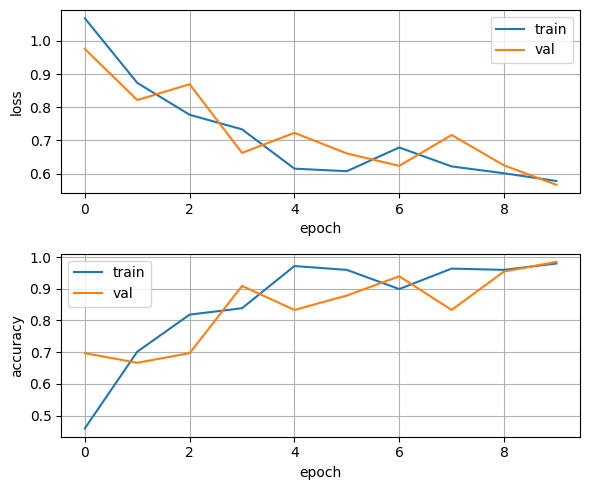

In [40]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

# 15. 테스트 이미지를 통한 학습모델 분류 성능 검증하기

In [41]:
data_data = './Covid19-dataset/test/'
class_list = ['Covid', 'Normal', 'Viral Pneumonia']

test_normals_list = list_image_file(data_dir, 'Normal')
test_covids_list = list_image_file(data_dir, 'Covid')
test_pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [42]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    tensor_image = transformer(image) # (C, H, W) (color, height, width)
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W) # 0의 자리에 하나 차원이 늘어남.
                                                            # B는 batch_size
    return tensor_image

In [43]:
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _ , pred_label = torch.max(prediction.detach(), dim=1) 
    # 이미지와 라벨이 들어가있는데 그 라벨을 떼서 최대값을 뽑아서 붙인다.
    # 이미지는 필요없고 라벨값만 얻기 # 데이터가져와서 붙이기
    print('pred_label1 : ', pred_label)
    pred_label = pred_label.squeeze(0) # 0번에 있는 차원을 제거시키겠다(차원을 축소시키겠다)
    print('pred_label2 : ', pred_label)

    return pred_label.item() # 라벨값만 떼서 리턴

In [44]:
ckpt = torch.load('./trained_model/model_09.pth')

model = build_vgg19_based_model()
model.load_state_dict(ckpt) # 모델을 부르는 함수
model.eval() # 검증용

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list)) #최소값으로 저장

@interact(index=(0, min_num_files-1)) # 최대값을 min_num_files -1 로 잡는다

def show_result(index=0):
    normal_image = get_RGB_image(data_dir, test_normals_list[index])
    covid_image = get_RGB_image(data_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model) # normal값을 model에 넣어서 예측을 함
    prediction_2 = model_predict(covid_image, model) # covid값을 model에 넣어서 예측을 함
    prediction_3 = model_predict(pneumonia_image, model) # pneumonia값을 model에 넣어서 예측을 함
    
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(131)
    plt.title(f'Pred:{class_list[prediction_1]} | GT:Normal')
    plt.imshow(normal_image)
    
    plt.subplot(132)
    plt.title(f'Pred:{class_list[prediction_2]} | GT:Covid')
    plt.imshow(covid_image)
    
    plt.subplot(133)
    plt.title(f'Pred:{class_list[prediction_3]} | GT:Pneumonia')
    plt.imshow(pneumonia_image)
    
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 16. 정리
* CNN에 대한 학습
* 이미지 데이터셋 구축
* Torchvision transforms 라이브러리를 활용한 텐서형 데이터 변환
* VGG19모델을 불러와 Head 부분을 수정
* Cross entropy Loss Funtion, SGDM 적용
* 인간 추론원리와 닮은 딥러닝 결과 출력